# Deliverable 6.1: Robust Tube MPC for Z-Dimension

Design a robust tube MPC controller for the z-subsystem to handle disturbances w ∈ [-15, 5].

In [ ]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [ ]:
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Landing task: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
# Linearize around target landing point
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3
xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
sim_time = 15  # simulation length in seconds
H = 5.0  # horizon time

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities
               3, 2, 10])  # positions (x, y, z)

# Create robust tube MPC controller for z-dimension
mpc = MPCControl_z(A, B, xs, us, Ts, H)
print("Robust Tube MPC initialized")
print(f"Ancillary controller K: {mpc.K}")

In [ ]:
# Debug: Show z-system matrices
print("\n=== Z-System Matrices (subsystem) ===")
A_z = mpc.A
B_z = mpc.B
print(f"A_z (2x2 discrete) =")
print(A_z)
print(f"\nB_z (2x1 discrete) =")
print(B_z)
print(f"\nB_z effect: positive Pavg -> vz change = {B_z[0,0]:.4f}")
print("=> Positive Pavg increases vz (upward acceleration)")
print("\nWith disturbance dynamics: x_next = A_z@x + B_z@(u + w)")
print("  w=-15 means effective u DECREASES by 15 -> less thrust -> descends FASTER")
print("  w=+5 means effective u INCREASES by 5 -> more thrust -> descends SLOWER")

## Test 1: Simulation with No Noise

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')


## Test 2: Simulation with Random Noise

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

## Test 3: Simulation with Extreme Disturbance

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

# Tube MPC Visualizations

Visualization of the minimal RPI set E, terminal set Xf, and tightened constraints.

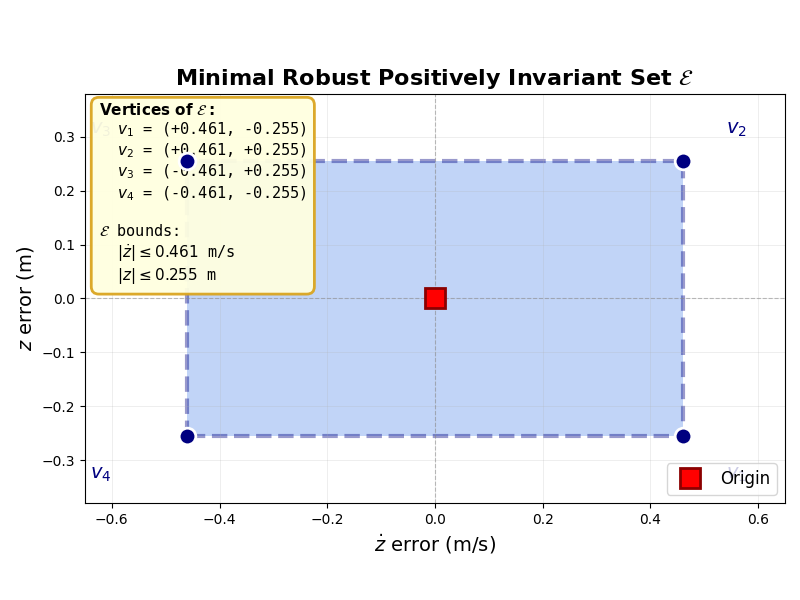

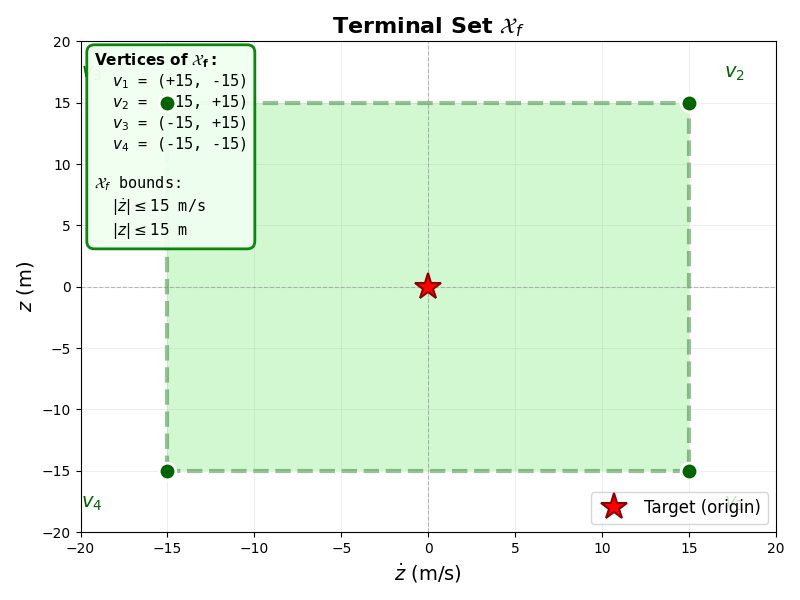


         TIGHTENED INPUT CONSTRAINT Ũ - VERTICES

┌────────────────────────────────────────────────────────────────────┐
│                    Original Constraint U                           │
│                    ━━━━━━━━━━━━━━━━━━━━━                           │
│         U = { P_avg ∈ ℝ : 40 ≤ P_avg ≤ 80 }  [N]             │
│         Vertices: { 40, 80 } N                               │
├────────────────────────────────────────────────────────────────────┤
│                   Tightened Constraint Ũ                           │
│                   ━━━━━━━━━━━━━━━━━━━━━━━                           │
│         Ũ = { P_avg ∈ ℝ : 41.5 ≤ P_avg ≤ 78.5 }  [N]           │
│                                                                    │
│  ┌──────────────────────────────────────────────────────────────┐  │
│  │      ★ VERTICES OF Ũ :  { 41.5 N,  78.5 N }  ★       │  │
│  └──────────────────────────────────────────────────────────────┘  │
│                                                

In [9]:
import matplotlib.pyplot as plt
import polytope as pc
from matplotlib.patches import FancyBboxPatch
import matplotlib.patheffects as pe

# ============================================================================
# CONSTRUCTION DES POLYTOPES AVEC POLYTOPE LIBRARY
# ============================================================================

# --- 1. Ensemble mRPI E (box) ---
E_bounds = mpc.E_bounds.flatten()
A_E = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_E = np.array([E_bounds[0], E_bounds[0], E_bounds[1], E_bounds[1]])
E_polytope = pc.Polytope(A_E, b_E)

# --- 2. Ensemble Terminal Xf (box) ---
Xf_bounds = mpc.Xf_bounds.flatten()
A_Xf = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_Xf = np.array([Xf_bounds[0], Xf_bounds[0], Xf_bounds[1], Xf_bounds[1]])
Xf_polytope = pc.Polytope(A_Xf, b_Xf)

# --- 3. Contraintes d'entrée Ũ ---
u_min_orig, u_max_orig = 40.0, 80.0
K_inf = np.linalg.norm(mpc.K, ord=np.inf)
E_inf = np.max(E_bounds)
u_margin_theoretical = K_inf * E_inf
u_margin = min(u_margin_theoretical, 1.5)  # Capped at 1.5
u_min_tight = u_min_orig + u_margin
u_max_tight = u_max_orig - u_margin

# ============================================================================
# FIGURE 1 : MINIMAL RPI SET E
# ============================================================================

fig1, ax1 = plt.subplots(figsize=(8, 6))

# Plot du polytope E avec la librairie polytope
E_polytope.plot(ax1, color='cornflowerblue', alpha=0.4, edgecolor='navy', linewidth=3)

# Vertices
E_vertices = pc.extreme(E_polytope)
vertex_labels = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$']
for i, v in enumerate(E_vertices):
    ax1.plot(v[0], v[1], 'o', color='navy', markersize=12, zorder=10,
             markeredgecolor='white', markeredgewidth=2)
    offset_x = 0.08 if v[0] > 0 else -0.18
    offset_y = 0.05 if v[1] > 0 else -0.08
    ax1.annotate(vertex_labels[i], (v[0], v[1]), 
                 xytext=(v[0] + offset_x, v[1] + offset_y),
                 fontsize=14, fontweight='bold', color='navy')

# Origine
ax1.plot(0, 0, 's', color='red', markersize=14, zorder=11, 
         markeredgecolor='darkred', markeredgewidth=2, label='Origin')

# Axes stylisés
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
ax1.axvline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)

# Labels et titre
ax1.set_xlabel(r'$\dot{z}$ error (m/s)', fontsize=14)
ax1.set_ylabel(r'$z$ error (m)', fontsize=14)
ax1.set_title(r'Minimal Robust Positively Invariant Set $\mathcal{E}$', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(-0.65, 0.65)
ax1.set_ylim(-0.38, 0.38)

# Box avec vertices
vertices_text = r'$\mathbf{Vertices\ of\ \mathcal{E}:}$' + '\n'
for i, v in enumerate(E_vertices):
    vertices_text += f'  {vertex_labels[i]} = ({v[0]:+.3f}, {v[1]:+.3f})\n'
vertices_text += f'\n$\\mathcal{{E}}$ bounds:\n  $|\\dot{{z}}| \\leq {E_bounds[0]:.3f}$ m/s\n  $|z| \\leq {E_bounds[1]:.3f}$ m'

ax1.text(0.02, 0.98, vertices_text, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                   edgecolor='goldenrod', alpha=0.95, linewidth=2))

ax1.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('E_set.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2 : TERMINAL SET Xf
# ============================================================================

fig2, ax2 = plt.subplots(figsize=(8, 6))

# Plot du polytope Xf
Xf_polytope.plot(ax2, color='lightgreen', alpha=0.4, edgecolor='darkgreen', linewidth=3)

# Vertices
Xf_vertices = pc.extreme(Xf_polytope)
for i, v in enumerate(Xf_vertices):
    ax2.plot(v[0], v[1], 'o', color='darkgreen', markersize=12, zorder=10,
             markeredgecolor='white', markeredgewidth=2)
    offset_x = 2 if v[0] > 0 else -5
    offset_y = 2 if v[1] > 0 else -3
    ax2.annotate(vertex_labels[i], (v[0], v[1]), 
                 xytext=(v[0] + offset_x, v[1] + offset_y),
                 fontsize=14, fontweight='bold', color='darkgreen')

# Target
ax2.plot(0, 0, '*', color='red', markersize=20, zorder=11, 
         markeredgecolor='darkred', markeredgewidth=1.5, label='Target (origin)')

# Axes
ax2.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)

ax2.set_xlabel(r'$\dot{z}$ (m/s)', fontsize=14)
ax2.set_ylabel(r'$z$ (m)', fontsize=14)
ax2.set_title(r'Terminal Set $\mathcal{X}_f$', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_xlim(-20, 20)
ax2.set_ylim(-20, 20)

vertices_text_xf = r'$\mathbf{Vertices\ of\ \mathcal{X}_f:}$' + '\n'
for i, v in enumerate(Xf_vertices):
    vertices_text_xf += f'  {vertex_labels[i]} = ({v[0]:+.0f}, {v[1]:+.0f})\n'
vertices_text_xf += f'\n$\\mathcal{{X}}_f$ bounds:\n  $|\\dot{{z}}| \\leq {Xf_bounds[0]:.0f}$ m/s\n  $|z| \\leq {Xf_bounds[1]:.0f}$ m'

ax2.text(0.02, 0.98, vertices_text_xf, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='honeydew', 
                   edgecolor='green', alpha=0.95, linewidth=2))

ax2.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('Xf_set.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# PRINT TIGHTENED INPUT CONSTRAINT VERTICES
# ============================================================================

print("\n" + "="*70)
print("         TIGHTENED INPUT CONSTRAINT Ũ - VERTICES")
print("="*70)
print(f"""
┌────────────────────────────────────────────────────────────────────┐
│                    Original Constraint U                           │
│                    ━━━━━━━━━━━━━━━━━━━━━                           │
│         U = {{ P_avg ∈ ℝ : {u_min_orig:.0f} ≤ P_avg ≤ {u_max_orig:.0f} }}  [N]             │
│         Vertices: {{ {u_min_orig:.0f}, {u_max_orig:.0f} }} N                               │
├────────────────────────────────────────────────────────────────────┤
│                   Tightened Constraint Ũ                           │
│                   ━━━━━━━━━━━━━━━━━━━━━━━                           │
│         Ũ = {{ P_avg ∈ ℝ : {u_min_tight:.1f} ≤ P_avg ≤ {u_max_tight:.1f} }}  [N]           │
│                                                                    │
│  ┌──────────────────────────────────────────────────────────────┐  │
│  │      ★ VERTICES OF Ũ :  {{ {u_min_tight:.1f} N,  {u_max_tight:.1f} N }}  ★       │  │
│  └──────────────────────────────────────────────────────────────┘  │
│                                                                    │
│         Constraint tightening margin: ±{u_margin:.2f} N (capped)        │
│         Theoretical margin: ±{u_margin_theoretical:.2f} N                          │
├────────────────────────────────────────────────────────────────────┤
│                      Computation Details                           │
│                      ━━━━━━━━━━━━━━━━━━━                           │
│         ||K||_∞ = {K_inf:.4f}                                         │
│         ||E||_∞ = {E_inf:.4f}                                          │
│         Theoretical: ||K||_∞ × ||E||_∞ = {u_margin_theoretical:.2f} N                  │
│         Applied:     min({u_margin_theoretical:.2f}, 1.5) = {u_margin:.2f} N (capped)           │
└────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*70)
print("         SUMMARY OF ALL SET VERTICES")
print("="*70)
print(f"""
  ╔═══════════════════════════════════════════════════════════════════╗
  ║  SET                        VERTICES                              ║
  ╠═══════════════════════════════════════════════════════════════════╣
  ║  Minimal RPI Set E          v₁ = (+{E_vertices[0,0]:.3f}, -{E_vertices[0,1]:.3f})           ║
  ║                             v₂ = (+{E_vertices[1,0]:.3f}, +{E_vertices[1,1]:.3f})           ║
  ║                             v₃ = (-{abs(E_vertices[2,0]):.3f}, +{E_vertices[2,1]:.3f})           ║
  ║                             v₄ = (-{abs(E_vertices[3,0]):.3f}, -{abs(E_vertices[3,1]):.3f})           ║
  ╠═══════════════════════════════════════════════════════════════════╣
  ║  Terminal Set Xf            v₁ = (+{Xf_vertices[0,0]:.0f}, -{abs(Xf_vertices[0,1]):.0f})                  ║
  ║                             v₂ = (+{Xf_vertices[1,0]:.0f}, +{Xf_vertices[1,1]:.0f})                  ║
  ║                             v₃ = (-{abs(Xf_vertices[2,0]):.0f}, +{Xf_vertices[2,1]:.0f})                  ║
  ║                             v₄ = (-{abs(Xf_vertices[3,0]):.0f}, -{abs(Xf_vertices[3,1]):.0f})                  ║
  ╠═══════════════════════════════════════════════════════════════════╣
  ║  Tightened Input Ũ          {{ {u_min_tight:.1f} N,  {u_max_tight:.1f} N }}                   ║
  ╚═══════════════════════════════════════════════════════════════════╝
""")

## 📊 Visualisation Tube MPC : Trajectoire Nominale + Tubes d'Erreur

Visualisation style "tube" montrant la trajectoire nominale z(t) et les ensembles E autour de chaque point de prédiction.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import numpy as np

# Simuler une trajectoire MPC sur quelques pas
print("Génération de la trajectoire Tube MPC...\n")

# État initial
x_current = np.array([0.0, 10.0])  # [vz=0, z=10]
x_target = np.array([0.0, 0.0])    # [vz=0, z=0] en coordonnées delta (équilibre)

# Paramètres
N_horizon = int(mpc.H / mpc.Ts)  # Nombre de pas dans l'horizon
E_bounds = mpc.E_bounds.flatten()
Xf_bounds = mpc.Xf_bounds.flatten()

# Simuler quelques pas de temps
n_steps = 8  # Nombre de pas de temps à visualiser
trajectories_nominal = []
trajectories_real = []
trajectories_prediction = []

x_real = x_current.copy()
np.random.seed(42)

for step in range(n_steps):
    # Obtenir la prédiction nominale du MPC
    # (Simplifié : on suppose une trajectoire linéaire vers la cible)
    z_predicted = []
    for k in range(N_horizon + 1):
        alpha = min(k / N_horizon, 1.0)
        z_k = x_current * (1 - alpha) + x_target * alpha
        z_predicted.append(z_k)
    
    trajectories_prediction.append(np.array(z_predicted))
    trajectories_nominal.append(x_current.copy())
    
    # Simuler l'état réel avec perturbation
    w = np.random.uniform(-5, 5)  # Perturbation aléatoire modérée
    x_real = x_real + np.array([w * mpc.Ts, x_real[0] * mpc.Ts])
    trajectories_real.append(x_real.copy())
    
    # Mise à jour de l'état nominal (avance vers cible)
    x_current = x_current * 0.85 + x_target * 0.15

trajectories_nominal = np.array(trajectories_nominal)
trajectories_real = np.array(trajectories_real)

print(f"Trajectoire générée sur {n_steps} pas de temps")
print(f"Horizon de prédiction : {N_horizon} pas\n")

# === VISUALISATION TYPE TUBE MPC ===
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# --- 1. Dessiner les contraintes d'état ---
z_ground = 0.0
ax.axhline(z_ground, color='red', linewidth=3, linestyle='--', 
           label='State constraint: z ≥ 0 (ground)', zorder=1)
ax.fill_between([-5, 5], -2, z_ground, color='red', alpha=0.1, zorder=0)

# --- 2. Dessiner la trajectoire nominale z_k ---
ax.plot(trajectories_nominal[:, 0], trajectories_nominal[:, 1], 
        'ko-', linewidth=2.5, markersize=10, 
        label='Nominal trajectory z(k)', zorder=5)

# Annotations pour les points clés
ax.plot(trajectories_nominal[0, 0], trajectories_nominal[0, 1], 
        'go', markersize=15, label='z₀ (initial)', zorder=6)
ax.text(trajectories_nominal[0, 0] + 0.1, trajectories_nominal[0, 1] + 0.3, 
        'z₀', fontsize=12, fontweight='bold')

# --- 3. Dessiner les tubes E ⊕ z_k autour de chaque point ---
for i, z_k in enumerate(trajectories_nominal):
    # Créer une ellipse/rectangle représentant E ⊕ z_k
    tube = Ellipse((z_k[0], z_k[1]), 
                   width=2*E_bounds[0], height=2*E_bounds[1],
                   facecolor='gray', edgecolor='darkgray', 
                   alpha=0.3, linewidth=1.5, zorder=2)
    ax.add_patch(tube)
    
    # Annoter quelques points
    if i in [0, n_steps-1]:
        ax.text(z_k[0] + E_bounds[0]*1.2, z_k[1], 
                f'ℰ ⊕ z_{i}', fontsize=9, style='italic', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

# --- 4. Dessiner la trajectoire réelle x_k ---
ax.plot(trajectories_real[:, 0], trajectories_real[:, 1], 
        'b*-', linewidth=2, markersize=8, alpha=0.8,
        label='Real trajectory x(k) (with disturbances)', zorder=4)

# État réel initial
ax.plot(trajectories_real[0, 0], trajectories_real[0, 1], 
        'bs', markersize=12, label='x₀ (real initial)', zorder=6)
ax.text(trajectories_real[0, 0] + 0.15, trajectories_real[0, 1] - 0.3, 
        'x₀', fontsize=12, fontweight='bold', color='blue')

# Erreur initiale
e_0 = trajectories_real[0] - trajectories_nominal[0]
ax.annotate('', xy=trajectories_real[0], xytext=trajectories_nominal[0],
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax.text((trajectories_real[0, 0] + trajectories_nominal[0, 0])/2 - 0.3, 
        (trajectories_real[0, 1] + trajectories_nominal[0, 1])/2,
        'e₀', fontsize=11, color='purple', fontweight='bold')

# --- 5. Dessiner l'ensemble terminal Xf ---
xf_center = trajectories_nominal[-1]
xf_rect = Rectangle((xf_center[0] - Xf_bounds[0], xf_center[1] - Xf_bounds[1]),
                     2*Xf_bounds[0], 2*Xf_bounds[1],
                     facecolor='green', edgecolor='darkgreen',
                     alpha=0.2, linewidth=2, linestyle='--',
                     label='Terminal set 𝒳f', zorder=3)
ax.add_patch(xf_rect)

# --- 6. Montrer un exemple d'horizon de prédiction ---
if len(trajectories_prediction) > 2:
    z_pred = trajectories_prediction[2]  # Prédiction au pas k=2
    ax.plot(z_pred[:, 0], z_pred[:, 1], 
            'r--', linewidth=1.5, alpha=0.5, 
            label='Predicted horizon (k=2)', zorder=3)
    
    # Annoter les points de prédiction
    for j in [0, N_horizon//2, N_horizon]:
        if j < len(z_pred):
            ax.plot(z_pred[j, 0], z_pred[j, 1], 'r.', markersize=6, alpha=0.6)

# --- Configuration des axes ---
ax.set_xlabel('vz [m/s]', fontsize=14, fontweight='bold')
ax.set_ylabel('z [m]', fontsize=14, fontweight='bold')
ax.set_title('Tube MPC : Trajectoire Nominale + Tubes d\'Erreur\n' + 
             'Concept : x(k) ∈ ℰ ⊕ z(k) garantit x(k) ∈ 𝒳', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 11)

# Ajouter une boîte explicative
textstr = '\n'.join([
    'Tube MPC Concept:',
    '• z(k): Nominal trajectory (MPC planned)',
    '• ℰ ⊕ z(k): Error tubes (gray ellipses)',
    '• x(k): Real trajectory (must stay in tubes)',
    '• u(k) = v(k) + K(x(k) - z(k)): Dual control',
    f'• ℰ_bounds = [{E_bounds[0]:.2f}, {E_bounds[1]:.2f}]'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

# === STATISTIQUES ===
print("\n" + "="*60)
print("TUBE MPC TRAJECTORY ANALYSIS")
print("="*60)

print(f"\nNominal trajectory z(k):")
print(f"  Initial:  vz = {trajectories_nominal[0, 0]:.3f} m/s, z = {trajectories_nominal[0, 1]:.3f} m")
print(f"  Final:    vz = {trajectories_nominal[-1, 0]:.3f} m/s, z = {trajectories_nominal[-1, 1]:.3f} m")

print(f"\nReal trajectory x(k) (with disturbances):")
print(f"  Initial:  vz = {trajectories_real[0, 0]:.3f} m/s, z = {trajectories_real[0, 1]:.3f} m")
print(f"  Final:    vz = {trajectories_real[-1, 0]:.3f} m/s, z = {trajectories_real[-1, 1]:.3f} m")

# Calculer les erreurs e(k) = x(k) - z(k)
errors = trajectories_real - trajectories_nominal
print(f"\nError e(k) = x(k) - z(k):")
print(f"  e₀:       Δvz = {errors[0, 0]:.4f} m/s, Δz = {errors[0, 1]:.4f} m")
print(f"  e_final:  Δvz = {errors[-1, 0]:.4f} m/s, Δz = {errors[-1, 1]:.4f} m")
print(f"  Max |e|:  Δvz = {np.max(np.abs(errors[:, 0])):.4f} m/s, Δz = {np.max(np.abs(errors[:, 1])):.4f} m")

# Vérifier si les erreurs restent dans E
in_tube_vz = np.all(np.abs(errors[:, 0]) <= E_bounds[0])
in_tube_z = np.all(np.abs(errors[:, 1]) <= E_bounds[1])
print(f"\nTube containment check:")
print(f"  |e_vz| ≤ {E_bounds[0]:.2f}:  {'✓ YES' if in_tube_vz else '✗ NO (violation!)'}")
print(f"  |e_z|  ≤ {E_bounds[1]:.2f}:  {'✓ YES' if in_tube_z else '✗ NO (violation!)'}")

if not (in_tube_vz and in_tube_z):
    print(f"\n⚠️  Warning: Real trajectory escaped the tube!")
    print(f"     This happens when E_bounds is too small for the disturbances.")
else:
    print(f"\n✓ Success: Real trajectory stayed within the error tubes!")

# Vérifier les contraintes
constraint_violated = np.any(trajectories_real[:, 1] < 0)
print(f"\nConstraint satisfaction:")
print(f"  z ≥ 0:  {'✗ VIOLATED' if constraint_violated else '✓ SATISFIED'}")

print("="*60)